### Download and Plot the Latest US Treasury Bonds Yield Curve

In [16]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

### Helper Functions

In [3]:
def find_crossings(series1, series2):
    # Find the crossings of Series 1 and Series 2
    crossing_series = pd.Series([0] * len(series1), index=series1.index)
    for i in range(1, len(series1)):
        if ((series1.iloc[i-1] < series2.iloc[i-1]) and (series1.iloc[i] >= series2.iloc[i])):
            crossing_series.iloc[i] = 1
        elif ((series1.iloc[i-1] >= series2.iloc[i-1]) and (series1.iloc[i] < series2.iloc[i])):
            crossing_series.iloc[i] = -1

    # print(series2)
    cross_up = []
    cross_down = []
    for i in series1.index: 
        if crossing_series.loc[i] == 1 : 
            cross_up.append(series1.loc[i])
            cross_down.append(np.nan)
        elif crossing_series.loc[i] == -1:
            cross_down.append(series1.loc[i])
            cross_up.append(np.nan)
        else:
            cross_down.append(np.nan)
            cross_up.append(np.nan)
        

    return crossing_series,cross_up,cross_down

def plot_crossing_series(series1,series2,crossed_up,crossed_down):
    ax = series1.plot(figsize=(15,6))
    ax.grid(True)
    series2.plot(ax=ax)
    
    # Plot the corressing up and down
    ax.plot(series1.index,crossed_up,marker='^',color='green', 
                markersize = 12, linewidth = 0, label = f'{series1.name} Crossed Up')
    ax.plot(series1.index,crossed_down,marker='v',color='red', 
                    markersize = 12, linewidth = 0, label = f'{series1.name} Crossed Down')
    ax.legend()
    ax.grid(which='both')

In [4]:
last_five_years = [str(int(datetime.date.today().year) - i) for i in range(0, 6)]
this_year = last_five_years[0]

### Get Latest Bond Yield Data from US Dept. of Treasury

In [5]:
import time

yield_curves = pd.DataFrame()
yield_curves_diff = pd.DataFrame()

for i in range(len(last_five_years)):
    ustd_url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/"+last_five_years[i]+"/all?type=daily_treasury_yield_curve&field_tdr_date_value="+last_five_years[i]+"&page&_format=csv"
    yield_curve_df = pd.read_csv(ustd_url)
    if('4 Mo' in yield_curve_df.columns):
        yield_curve_df = yield_curve_df.drop('4 Mo',axis=1)
    if i == 0: # Save this year data
        yield_curve_y0_df = yield_curve_df
        
    yc_1 = yield_curve_df.copy(deep=True)
    yc_1['Date'] = pd.to_datetime(yc_1['Date'])
    yc_1 = yc_1.set_index('Date')
    
    for j in range(1,len(yc_1.columns)): 
        yc_1.iloc[1:,j] = pd.to_numeric(yc_1.iloc[1:,j],errors='coerce') 
        
    yield_curves = pd.concat([yield_curves,yc_1])
    # yield_curves = y.groupby(level=0)
    
    yc_1_diff = round(yc_1.pct_change(periods=1)*100,3)
    yc_1_diff.dropna()
    
    yield_curves_diff = pd.concat([yield_curves_diff,yc_1_diff])
    # yield_curves_diff = yd.groupby()
    
    # print(yield_curves)
    print(".", end='')
    time.sleep(2)
    

......

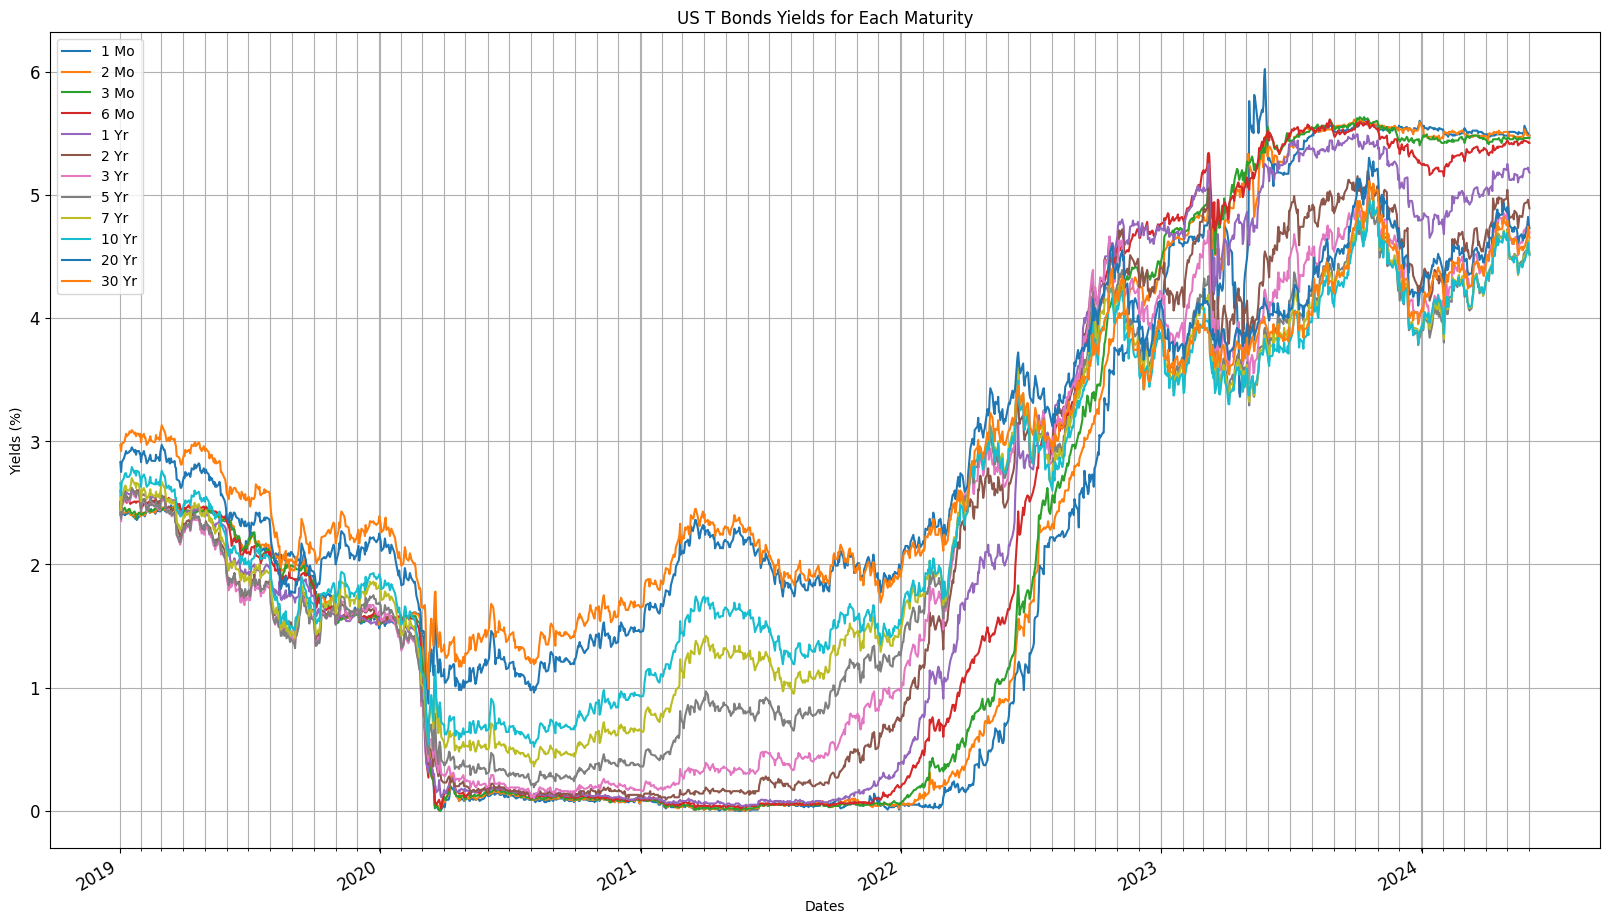

In [6]:
ax = yield_curves.plot(figsize=(20,12),grid=True,xlabel='Dates',ylabel='Yields (%)',
                  title='US T Bonds Yields for Each Maturity',fontsize=12)
xtick = pd.date_range( start=yield_curves.index.min( ), end=yield_curves.index.max( ), freq='ME' )
ax.set_xticks( xtick, minor=True )
ax.grid('on', which='minor', axis='x' )

### Create Data Series

In [7]:
# print('Yield Data:')
# # display(yield_curve_df)
# yc_1 = yield_curve_df.copy(deep=True)
# yc_1['Date'] = pd.to_datetime(yc_1['Date'])
# yc_1 = yc_1.set_index('Date')
# # print(yc_1.index)
# for i in range(1,len(yc_1.columns)): 
#     yc_1.iloc[1:,i] = pd.to_numeric(yc_1.iloc[1:,i],errors='coerce') 
# # yc_1.info()
# yc_1_diff = round(yc_1.pct_change(periods=1)*100,3)
# yc_1_diff.dropna()
yield_curves.iloc[:8,4:]


,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,
2024-05-31,5.18,4.89,4.69,4.52,4.52,4.51,4.73,4.65
2024-05-30,5.19,4.92,4.74,4.57,4.57,4.55,4.76,4.69
2024-05-29,5.22,4.96,4.79,4.63,4.63,4.61,4.82,4.74
2024-05-28,5.21,4.94,4.75,4.56,4.56,4.54,4.74,4.66
2024-05-24,5.21,4.93,4.71,4.53,4.49,4.46,4.65,4.57
2024-05-23,5.20,4.91,4.71,4.52,4.50,4.47,4.67,4.58
2024-05-22,5.16,4.86,4.64,4.47,4.44,4.43,4.63,4.55
2024-05-21,5.14,4.82,4.61,4.43,4.42,4.41,4.65,4.55


### Check Long-End vs. Short End Crossing

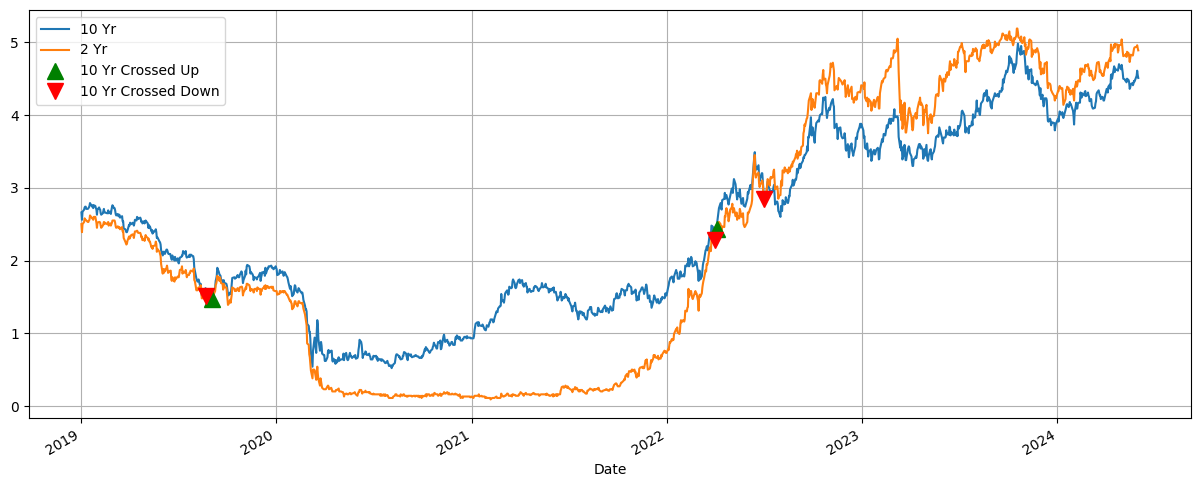

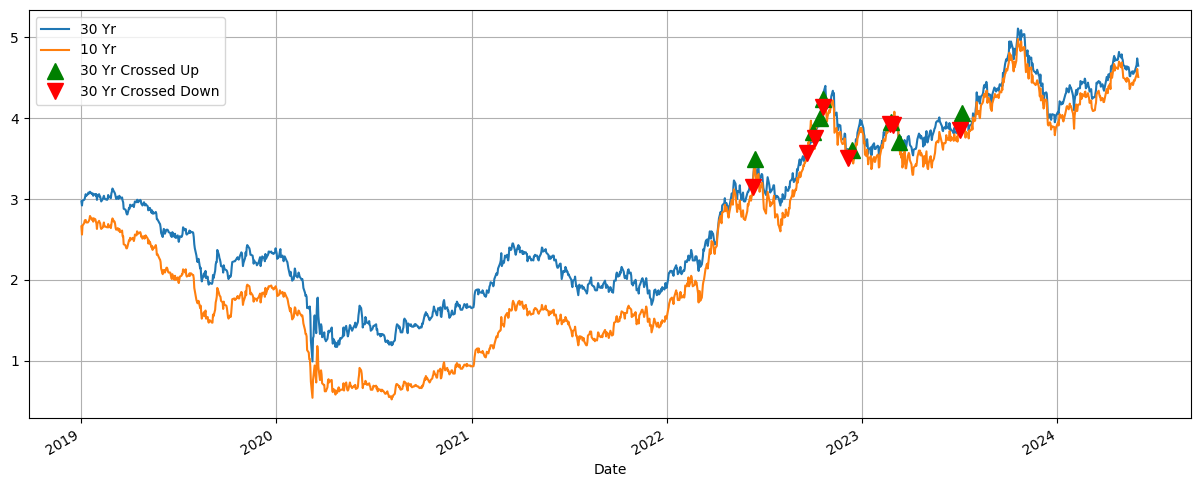

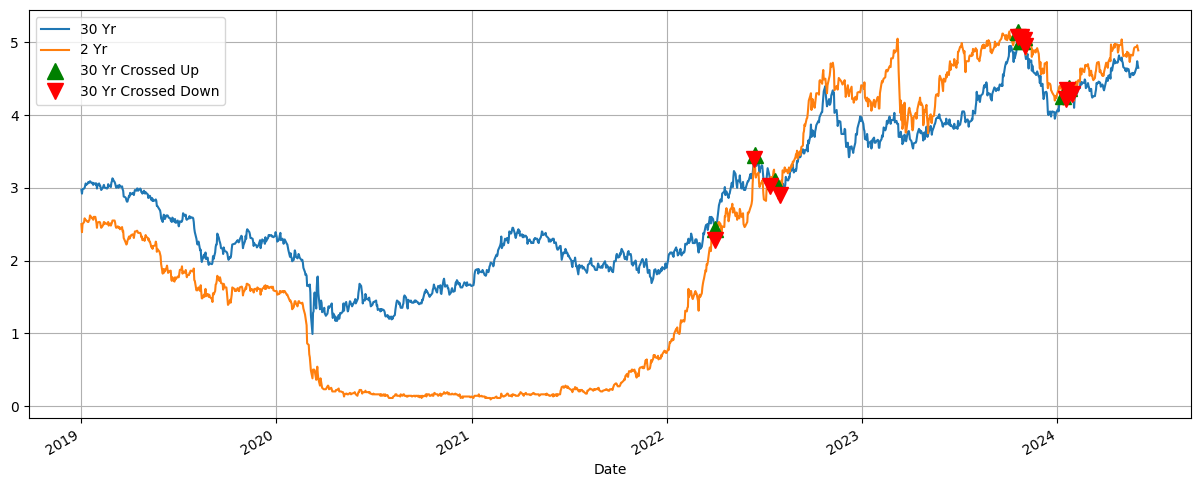

In [8]:
crossing_series, crossed_up, crossed_down=find_crossings(yield_curves['2 Yr'],yield_curves['10 Yr'])

plot_crossing_series(series2=yield_curves['2 Yr'],series1=yield_curves['10 Yr'],
                     crossed_up=crossed_up,crossed_down=crossed_down)
plt.show()

crossing_series, crossed_up, crossed_down=find_crossings(yield_curves['10 Yr'],yield_curves['30 Yr'])

plot_crossing_series(series2=yield_curves['10 Yr'],series1=yield_curves['30 Yr'],
                     crossed_up=crossed_up,crossed_down=crossed_down)
plt.show()


crossing_series, crossed_up, crossed_down=find_crossings(yield_curves['2 Yr'],yield_curves['30 Yr'])

plot_crossing_series(series2=yield_curves['2 Yr'],series1=yield_curves['30 Yr'],
                     crossed_up=crossed_up,crossed_down=crossed_down)
plt.show()

### Check for other Anomalies in the Long-Short Curves Data

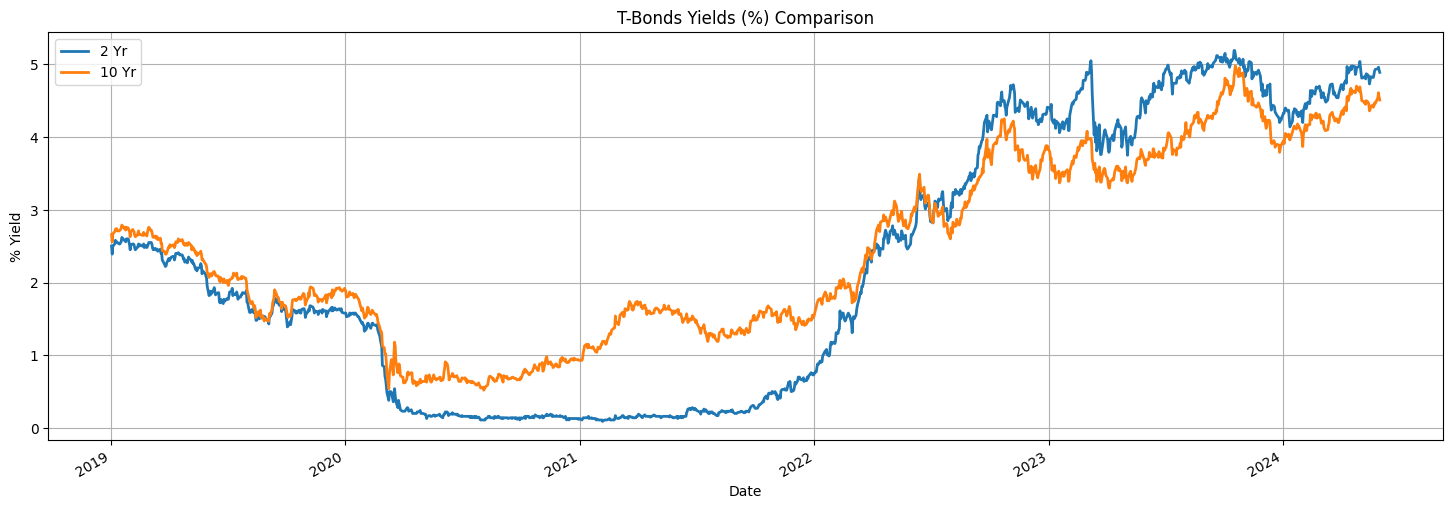

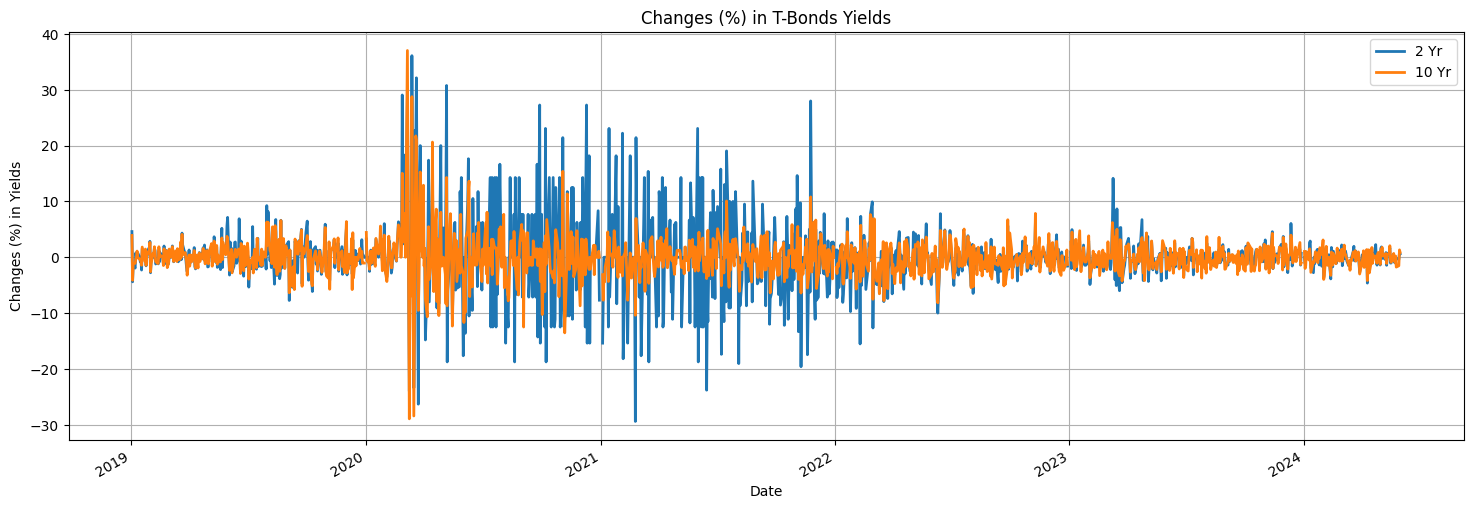

In [9]:

# Plot all
yield_curves[['2 Yr','10 Yr']].plot(figsize=(18,6),grid=True,
                            lw=2,xlabel='Date',ylabel='% Yield',
                            title="T-Bonds Yields (%) Comparison")
yield_curves_diff[['2 Yr','10 Yr']].plot(figsize=(18,6),grid=True,
                                 lw=2,xlabel='Date',ylabel='Changes (%) in Yields',
                                 title="Changes (%) in T-Bonds Yields")

plt.show()

### T-Bonds Vs. S&P 500 

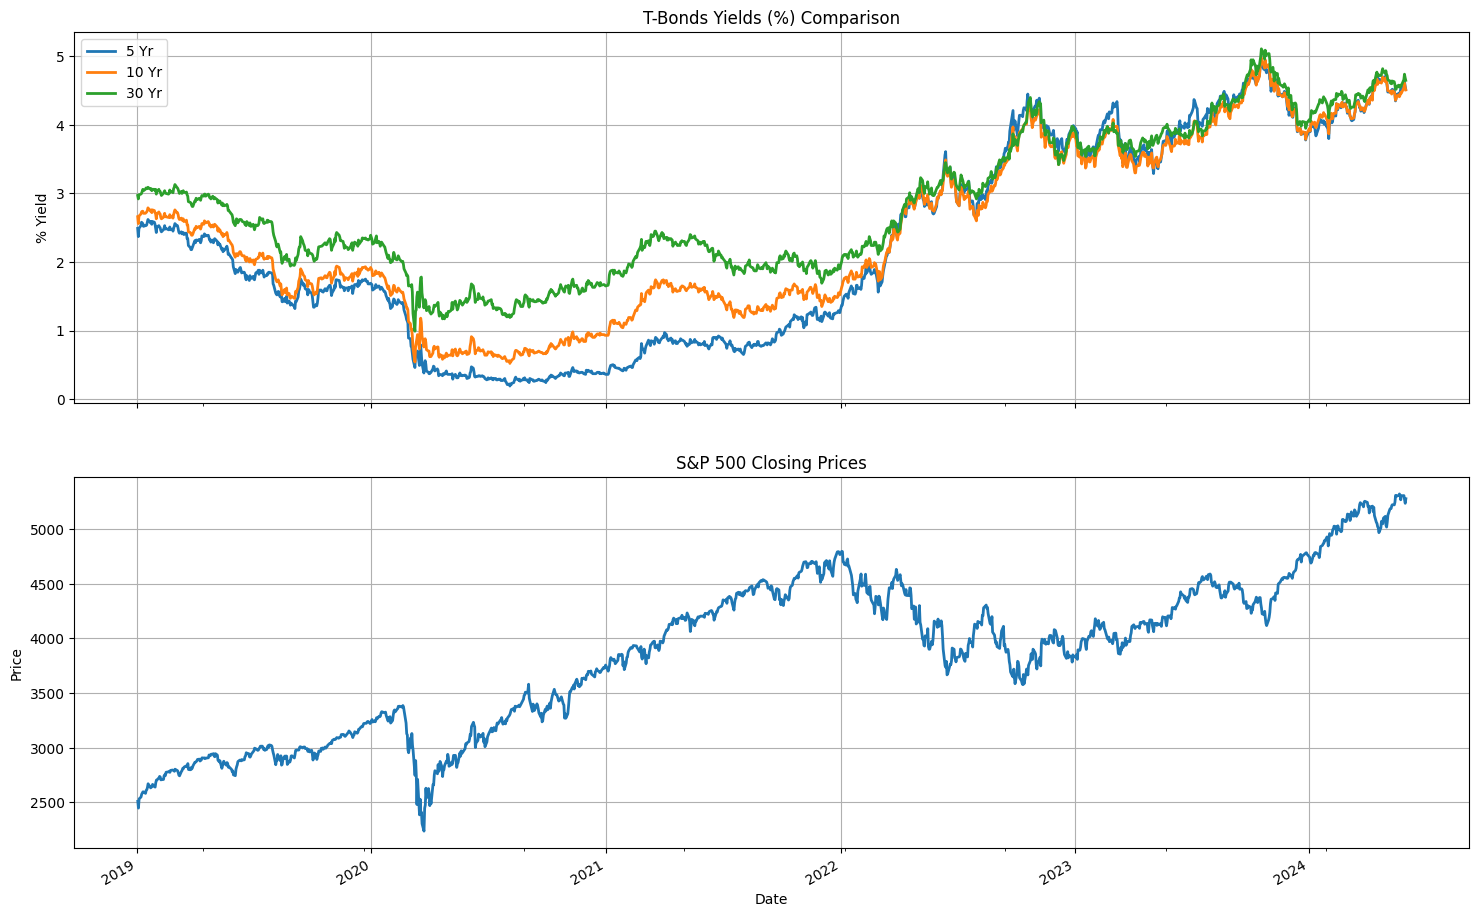

In [10]:

fig, ax = plt.subplots(2,1,figsize=(18,12),sharex=True)
yield_curves[['5 Yr','10 Yr','30 Yr']].plot(ax=ax[0],grid=True,
                            lw=2,xlabel='Date',ylabel='% Yield',
                            title="T-Bonds Yields (%) Comparison")

start_date = yield_curves.index[-1].strftime("%Y-%m-%d")
df_sp500 = yf.Ticker('^GSPC').history(start=start_date,interval='1d')['Close']


df_sp500.plot(ax=ax[1],grid=True,
                            lw=2,xlabel='Date',ylabel='Price',
                            title="S&P 500 Closing Prices")
plt.show()

S&P 500 Correlation with Bond Yields :
   Maturities  Correlations
0        1 Mo      0.363018
1        2 Mo      0.366356
2        3 Mo      0.369470
3        6 Mo      0.374113
4        1 Yr      0.381836
5        2 Yr      0.408745
6        3 Yr      0.430909
7        5 Yr      0.472786
8        7 Yr      0.499192
9       10 Yr      0.512861
10      20 Yr      0.552181
11      30 Yr      0.512445


<Axes: title={'center': 'S&P 500 Prices Correlation with T Bond Yields'}, xlabel='T Bonds by Maturity', ylabel='Corr with S&P 500'>

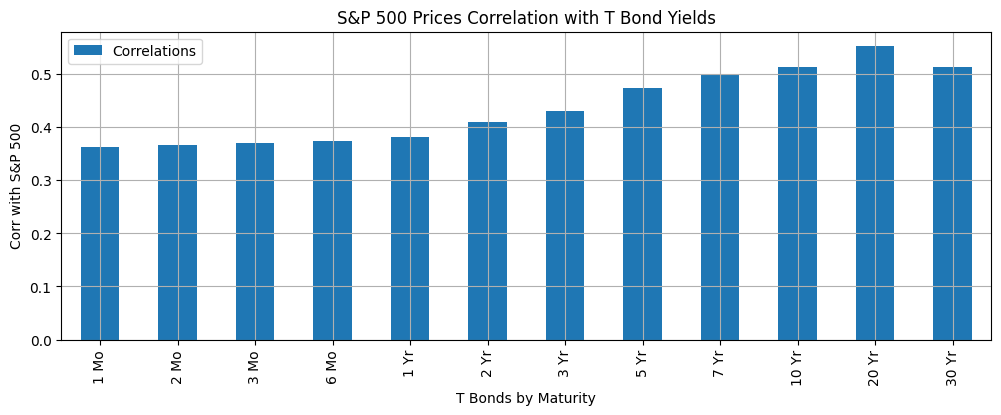

In [11]:
corr_with_bond = yield_curves.tz_localize('America/New_York').corrwith(df_sp500)
# corr_with_bond.values
corr_with_bond_df = pd.DataFrame({'Maturities':corr_with_bond.index,'Correlations':corr_with_bond.values})
print("S&P 500 Correlation with Bond Yields :")
print(corr_with_bond_df)
corr_with_bond_df.plot.bar(x='Maturities',y='Correlations',figsize=(12,4),
                           title="S&P 500 Prices Correlation with T Bond Yields",ylabel="Corr with S&P 500",
                           xlabel='T Bonds by Maturity',grid=True)

### Re-Formating and Cleaning the Data into a DataFrame

In [12]:
yield_curve_df2 = yield_curve_y0_df.reset_index()
yield_curve_df2 = yield_curve_df2.T
yield_curve_df2 = yield_curve_df2.reset_index()

yield_curve_df2 = yield_curve_df2.drop([0])
yield_curve_df2.iloc[0,0] = 'Maturity'
cols = [str(x) for x in yield_curve_df2.iloc[0,:]]

In [13]:
yield_curve_df2.columns = cols
yield_curve_df2 = yield_curve_df2.iloc[1:,:].copy()
yield_curve_df2.reset_index(inplace=True)
yield_curve_df2.drop(['index'],axis=1,inplace=True)
yield_curve_df2 = yield_curve_df2.set_index('Maturity')
yield_curve_df2

,05/31/2024,05/30/2024,05/29/2024,05/28/2024,05/24/2024,05/23/2024,05/22/2024,05/21/2024,05/20/2024,05/17/2024,...,01/16/2024,01/12/2024,01/11/2024,01/10/2024,01/09/2024,01/08/2024,01/05/2024,01/04/2024,01/03/2024,01/02/2024
Maturity,,,,,,,,,,,,,,,,,,,,,
1 Mo,5.48,5.48,5.5,5.5,5.56,5.51,5.49,5.5,5.5,5.5,...,5.54,5.55,5.54,5.53,5.53,5.54,5.54,5.56,5.54,5.55
2 Mo,5.48,5.48,5.48,5.48,5.53,5.48,5.48,5.47,5.47,5.47,...,5.47,5.47,5.47,5.46,5.46,5.48,5.48,5.48,5.54,5.54
3 Mo,5.46,5.46,5.46,5.46,5.46,5.46,5.45,5.45,5.45,5.46,...,5.45,5.45,5.46,5.46,5.47,5.49,5.47,5.48,5.48,5.46
6 Mo,5.42,5.42,5.43,5.43,5.44,5.44,5.43,5.42,5.43,5.41,...,5.18,5.16,5.22,5.23,5.24,5.24,5.24,5.25,5.25,5.24
1 Yr,5.18,5.19,5.22,5.21,5.21,5.2,5.16,5.14,5.15,5.14,...,4.7,4.65,4.75,4.82,4.82,4.82,4.84,4.85,4.81,4.8
2 Yr,4.89,4.92,4.96,4.94,4.93,4.91,4.86,4.82,4.82,4.83,...,4.22,4.14,4.26,4.37,4.36,4.36,4.4,4.38,4.33,4.33
3 Yr,4.69,4.74,4.79,4.75,4.71,4.71,4.64,4.61,4.62,4.6,...,4.02,3.92,4.02,4.1,4.09,4.11,4.17,4.14,4.07,4.09
5 Yr,4.52,4.57,4.63,4.56,4.53,4.52,4.47,4.43,4.46,4.44,...,3.95,3.84,3.9,3.99,3.97,3.97,4.02,3.97,3.9,3.93
7 Yr,4.52,4.57,4.63,4.56,4.49,4.5,4.44,4.42,4.44,4.43,...,4.01,3.91,3.95,4.01,4.0,3.99,4.04,3.99,3.92,3.95


### Plot the Most Recent Yield Curves

In [17]:
longest_n_maturities = 8   # For ALL maturities set = len(yield_curve_df2)
last_n_days = 5            # For ALL days in the data set = -1
fig = px.line(yield_curve_df2.iloc[-longest_n_maturities:,:last_n_days],markers=True)

fig.update_layout(
    width=1200,
    height=600,
   title="US Treasury Bonds Yield Curve",
   xaxis_title='Bond Maturity',
   yaxis_title='Interest Rate %',
   legend_title="Curve Date",
   font=dict(
      family="Arial",
      size=20,
      color="blue"
   )
)
fig.show()

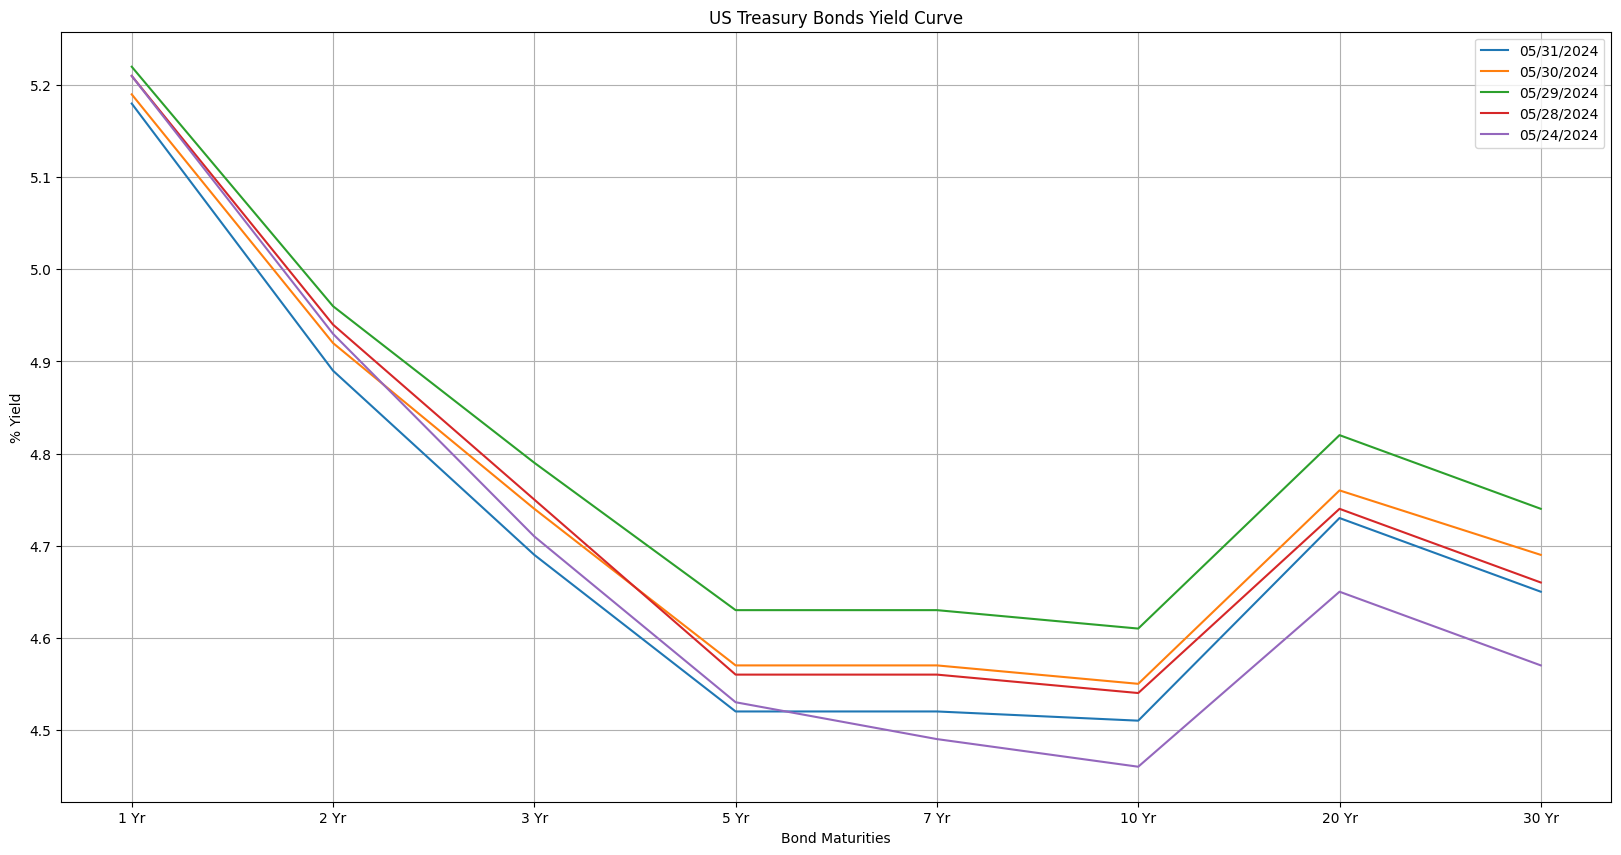

In [18]:
yield_curve_df2.iloc[-8:,:5].plot(figsize=(20,10),title="US Treasury Bonds Yield Curve",ylabel='% Yield',
                     xlabel='Bond Maturities',grid=True)
plt.show()